In [33]:
!pip install xgboost tensorflow keras seaborn matplotlib pandas scikit-learn streamlit joblib plotly google-genai

  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_inspection-0.4.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   --------------- ------------------------ 0.8/2.0 MB 4.0 MB/s eta 0:00:01
   ------------------------------------ --- 1.8/2.0 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 4.5 MB/s  0:00:00
Using cached rsa-4.9.1-py3-none-any.whl (34 kB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Using cached pyasn1-0.6.1-py3-none-any.whl (83 kB)
Using cached pyasn1_modules-0.4.2-py3-none-any.whl (181 kB)
Using cached typing_inspection-0.4.2-py3-none-any.whl (14 kB)
Using cached sniffio-1

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# --- 1. Load Your Final, Model-Ready Dataset ---
try:
    df = pd.read_csv("D:\\python_progs\\final_proj\\notebooks\\Verified_Cancer_Essential_Dataset.csv")
except FileNotFoundError:
    print("Error: 'model_training_dataset.csv' not found.")
    print("Please run the previous feature selection script first.")
    # Stop execution if file isn't found
    exit()

print(f"Loaded full dataset with {len(df)} rows.")

col=['Protein','Gene Names']
df.drop(columns=col,inplace=True)

# --- 2. Separate Positive and Negative Samples ---
df_positive = df[df['Label'] == 1]
df_negative_all = df[df['Label'] == 0]

num_positive = len(df_positive)

print(f"Total Positive (1) Samples: {num_positive}")
print(f"Total Negative (0) Samples: {len(df_negative_all)}")

# --- 3. Sub-divide the Negative Samples ---
# We assume 'Degree_Centrality' is the column to check.
# If it's 0, all other centrality features are also 0.
df_neg_nonzero = df_negative_all[df_negative_all['Degree_Centrality'] > 0]
df_neg_zero = df_negative_all[df_negative_all['Degree_Centrality'] == 0]

print(f"Found {len(df_neg_nonzero)} negative samples with non-zero centrality.")
print(f"Found {len(df_neg_zero)} negative samples with zero centrality.")

# --- 4. Create Dataset 1 (Non-Zero Negatives) ---
print("\n--- Creating Dataset 1 (Non-Zero Negatives) ---")
if len(df_neg_nonzero) >= num_positive:
    df_neg_nonzero_sample = df_neg_nonzero.sample(n=num_positive, random_state=42)
    df_dataset1 = pd.concat([df_positive, df_neg_nonzero_sample])
    df_dataset1 = shuffle(df_dataset1, random_state=42) # Shuffle rows
    df_dataset1.to_csv("dataset_1_balanced_nonzero.csv", index=False)
    print(f"Saved 'dataset_1_balanced_nonzero.csv' with {len(df_dataset1)} rows.")
else:
    print(f"Warning: Not enough non-zero negatives ({len(df_neg_nonzero)}) to match positives ({num_positive}).")
    print("This dataset will be smaller and imbalanced.")

# --- 5. Create Dataset 2 (Zero Negatives) ---
print("\n--- Creating Dataset 2 (Zero Negatives) ---")
if len(df_neg_zero) >= num_positive:
    df_neg_zero_sample = df_neg_zero.sample(n=num_positive, random_state=42)
    df_dataset2 = pd.concat([df_positive, df_neg_zero_sample])
    df_dataset2 = shuffle(df_dataset2, random_state=42) # Shuffle rows
    df_dataset2.to_csv("dataset_2_balanced_zero.csv", index=False)
    print(f"Saved 'dataset_2_balanced_zero.csv' with {len(df_dataset2)} rows.")
else:
    print(f"Warning: Not enough zero negatives ({len(df_neg_zero)}) to match positives ({num_positive}).")

# --- 6. Create Dataset 3 (Mixed Negatives) ---
print("\n--- Creating Dataset 3 (Mixed Negatives) ---")
df_neg_mixed_sample = df_negative_all.sample(n=num_positive, random_state=42)
df_dataset3 = pd.concat([df_positive, df_neg_mixed_sample])
df_dataset3 = shuffle(df_dataset3, random_state=42) # Shuffle rows
df_dataset3.to_csv("dataset_3_balanced_mixed.csv", index=False)
print(f"Saved 'dataset_3_balanced_mixed.csv' with {len(df_dataset3)} rows.")

print("\n✅ All 3 balanced datasets created.")

Loaded full dataset with 20420 rows.
Total Positive (1) Samples: 1946
Total Negative (0) Samples: 18474
Found 11130 negative samples with non-zero centrality.
Found 7344 negative samples with zero centrality.

--- Creating Dataset 1 (Non-Zero Negatives) ---
Saved 'dataset_1_balanced_nonzero.csv' with 3892 rows.

--- Creating Dataset 2 (Zero Negatives) ---
Saved 'dataset_2_balanced_zero.csv' with 3892 rows.

--- Creating Dataset 3 (Mixed Negatives) ---
Saved 'dataset_3_balanced_mixed.csv' with 3892 rows.

✅ All 3 balanced datasets created.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, average_precision_score


In [9]:
# --- 1. Load the BALANCED Dataset ---
df = pd.read_csv("D:\\python_progs\\final_proj\\notebooks\\Final_Cancer_Essential_Dataset_Localized.csv")

# --- 2. Separate features (X) and target (y) ---
y = df['Label']
X = df.drop(columns=['Label','Protein', 'Gene Names'])
print(f"Balanced dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# --- 3. Impute and Split ---

imputer = SimpleImputer(strategy='constant', fill_value=0)
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, 
    test_size=0.2,    # 20% for testing
    random_state=42
)

# --- 4. Scale Data ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data is split, imputed, and scaled. Ready for training.")

Balanced dataset shape: (4946, 34)
Target distribution:
Label
0    3000
1    1946
Name: count, dtype: int64
Data is split, imputed, and scaled. Ready for training.


In [20]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, confusion_matrix

print("--- 1. Calculating Class Weights for Imbalance ---")
# Calculate ratio for XGBoost (Negatives / Positives)
count_neg = len(y_train) - y_train.sum()
count_pos = y_train.sum()
scale_weight = count_neg / count_pos
print(f"Positive samples: {count_pos}, Negative samples: {count_neg}")
print(f"XGBoost scale_pos_weight: {scale_weight:.2f}")

# ==========================================
# 2. RANDOM FOREST TUNING
# ==========================================
print("\n--- Starting Hyperparameter Tuning for Random Forest ---")

param_grid_rf = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample'] # Key for boosting Recall
}

rf_base = RandomForestClassifier(random_state=42)

# Using Recall as scoring to prioritize finding Essentials
grid_search_rf = GridSearchCV(estimator=rf_base, param_grid=param_grid_rf, 
                           cv=3, n_jobs=-1, scoring='f1_weighted', verbose=1)

grid_search_rf.fit(X_train_scaled, y_train)
best_rf_model = grid_search_rf.best_estimator_
print(f"Best RF Params: {grid_search_rf.best_params_}")

# ==========================================
# 3. XGBOOST TUNING
# ==========================================
print("\n--- Starting Hyperparameter Tuning for XGBoost ---")

param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'scale_pos_weight': [1, scale_weight], # Try default and calculated weight
    'subsample': [0.8, 1.0]
}

xgb_base = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# RandomizedSearch is faster for XGBoost
random_search_xgb = RandomizedSearchCV(estimator=xgb_base, param_distributions=param_grid_xgb,
                                    n_iter=10, cv=3, n_jobs=-1, scoring='f1_weighted', verbose=1, random_state=42)

random_search_xgb.fit(X_train_scaled, y_train)
best_xgb_model = random_search_xgb.best_estimator_
print(f"Best XGB Params: {random_search_xgb.best_params_}")

# ==========================================
# 4. FINAL EVALUATION WITH RECALL OPTIMIZATION
# ==========================================
print("\n" + "="*40)
print("--- FINAL EVALUATION (Recall Optimized) ---")
print("="*40)

def evaluate_with_threshold(model, X, y, threshold=0.35, model_name="Model"):
    # Get probabilities instead of 0/1
    y_probs = model.predict_proba(X)[:, 1]
    
    # Apply custom threshold (Lower threshold = Higher Recall)
    y_pred_custom = (y_probs >= threshold).astype(int)
    
    print(f"\n>> {model_name} (Threshold: {threshold})")
    print(f"F1-Score: {f1_score(y, y_pred_custom):.4f}")
    print(f"Recall (Essentials Found): {recall_score(y, y_pred_custom):.4f}")
    print(f"Precision: {precision_score(y, y_pred_custom):.4f}")
    print("-" * 30)
    print(classification_report(y, y_pred_custom))
    
    # Show confusion matrix to see how many essentials were missed
    cm = confusion_matrix(y, y_pred_custom)
    print(f"Essentials Missed (False Negatives): {cm[1][0]}")
    print(f"Essentials Found (True Positives):  {cm[1][1]}")


--- 1. Calculating Class Weights for Imbalance ---
Positive samples: 1556, Negative samples: 2400
XGBoost scale_pos_weight: 1.54

--- Starting Hyperparameter Tuning for Random Forest ---
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best RF Params: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 300}

--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits


d:\python_progs\final_proj\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:17:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB Params: {'subsample': 0.8, 'scale_pos_weight': np.float64(1.5424164524421593), 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01}

--- FINAL EVALUATION (Recall Optimized) ---


In [21]:
# Evaluate Random Forest
evaluate_with_threshold(best_rf_model, X_test_scaled, y_test, threshold=0.38, model_name="Tuned Random Forest")

# Evaluate XGBoost (Usually the best performer)
evaluate_with_threshold(best_xgb_model, X_test_scaled, y_test, threshold=0.38, model_name="Tuned XGBoost")


>> Tuned Random Forest (Threshold: 0.38)
F1-Score: 0.7241
Recall (Essentials Found): 0.8513
Precision: 0.6300
------------------------------
              precision    recall  f1-score   support

           0       0.87      0.68      0.76       600
           1       0.63      0.85      0.72       390

    accuracy                           0.74       990
   macro avg       0.75      0.76      0.74       990
weighted avg       0.78      0.74      0.75       990

Essentials Missed (False Negatives): 58
Essentials Found (True Positives):  332

>> Tuned XGBoost (Threshold: 0.38)
F1-Score: 0.7309
Recall (Essentials Found): 0.8077
Precision: 0.6674
------------------------------
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       600
           1       0.67      0.81      0.73       390

    accuracy                           0.77       990
   macro avg       0.76      0.77      0.76       990
weighted avg       0.78      0.77      0.77

In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import precision_recall_curve

print("--- 1. ADVANCED FEATURE SELECTION ---")
# Use the best XGBoost model to find the most useful features
# This removes "noise" that lowers Precision
selection = SelectFromModel(best_xgb_model, threshold='median', prefit=True)
X_train_reduced = selection.transform(X_train_scaled)
X_test_reduced = selection.transform(X_test_scaled)

print(f"Original Feature Count: {X_train_scaled.shape[1]}")
print(f"Reduced Feature Count:  {X_train_reduced.shape[1]}")

# We must retrain the base models on the reduced feature set
print("\n--- Retraining Base Models on Reduced Features ---")
rf_clean = best_rf_model  # Reuse best params
rf_clean.fit(X_train_reduced, y_train)

xgb_clean = best_xgb_model # Reuse best params
xgb_clean.fit(X_train_reduced, y_train)

# ==========================================
# 2. ENSEMBLE LEARNING (VOTING CLASSIFIER)
# ==========================================
print("\n--- 2. Building Voting Ensemble ---")
# Soft Voting averages the probabilities of both models
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clean), ('xgb', xgb_clean)],
    voting='soft',
    weights=[1, 2] # Give XGBoost (Higher Precision) slightly more weight
)

voting_clf.fit(X_train_reduced, y_train)
print("✅ Ensemble Training Complete.")

# ==========================================
# 3. FINDING THE PERFECT THRESHOLD
# ==========================================
print("\n--- 3. Optimizing Threshold for Max F1-Score ---")

# Get probabilities
y_probs_ensemble = voting_clf.predict_proba(X_test_reduced)[:, 1]

# Calculate Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_ensemble)

# Calculate F1 score for every possible threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
# Handle potential division by zero
f1_scores = np.nan_to_num(f1_scores)

# Find the index of the best F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🚀 OPTIMAL THRESHOLD FOUND: {best_threshold:.4f}")
print(f"🚀 EXPECTED MAX F1-SCORE: {best_f1:.4f}")

# ==========================================
# 4. FINAL EVALUATION
# ==========================================
print("\n" + "="*40)
print("--- FINAL ENSEMBLE RESULTS ---")
print("="*40)

# Apply the optimal threshold
y_pred_optimal = (y_probs_ensemble >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_optimal))

# Confusion Matrix details
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_optimal)
print(f"Essentials Missed (FN): {cm[1][0]}")
print(f"Essentials Found (TP):  {cm[1][1]}")
print(f"False Alarms (FP):      {cm[0][1]}")



--- 1. ADVANCED FEATURE SELECTION ---
Original Feature Count: 34
Reduced Feature Count:  17

--- Retraining Base Models on Reduced Features ---


d:\python_progs\final_proj\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- 2. Building Voting Ensemble ---


d:\python_progs\final_proj\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:20:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Ensemble Training Complete.

--- 3. Optimizing Threshold for Max F1-Score ---
🚀 OPTIMAL THRESHOLD FOUND: 0.4069
🚀 EXPECTED MAX F1-SCORE: 0.7277

--- FINAL ENSEMBLE RESULTS ---
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       600
           1       0.66      0.81      0.73       390

    accuracy                           0.76       990
   macro avg       0.76      0.77      0.76       990
weighted avg       0.78      0.76      0.77       990

Essentials Missed (FN): 76
Essentials Found (TP):  314
False Alarms (FP):      159


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight

# --- 1. Load and Prepare Data ---
df = pd.read_csv("D:\\python_progs\\final_proj\\notebooks\\Final_Cancer_Essential_Dataset_Localized.csv")
y = df['Label']
X = df.drop(columns=['Label','Protein', 'Gene Names'])

# Impute and Split
imputer = SimpleImputer(strategy='constant', fill_value=0)
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# Scale (Critical for Neural Networks!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 2. Calculate Class Weights ---
# This tells the NN to pay way more attention to the "Essential" class
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weight_dict}")

# --- 3. Build the Neural Network ---
model = keras.Sequential([
    # Input Layer (18 features)
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3), # Helps prevent overfitting
    
    # Hidden Layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    
    # Output Layer (1 neuron, sigmoid for probability 0-1)
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
# We use a low learning rate (0.001) for stability
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='pr_auc', curve='PR')] # Optimize for Precision-Recall AUC
)

model.summary()

Class Weights: {0: np.float64(0.8241666666666667), 1: np.float64(1.2712082262210798)}


d:\python_progs\final_proj\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# --- 4. Train the Model ---
print("\nTraining Neural Network...")
history = model.fit(
    X_train_scaled, y_train,
    batch_size=32,
    epochs=50,               # Run for 50 epochs
    class_weight=class_weight_dict, # Use the weights we calculated
    validation_split=0.2,    # Use 20% of training data to check progress
    verbose=1
)

# --- 5. Evaluate ---
print("\nEvaluating on Test Set...")
# Get probabilities
y_pred_proba = model.predict(X_test_scaled)

# Convert probabilities to 0 or 1 (using 0.5 as threshold)
y_pred_dl = (y_pred_proba > 0.5).astype(int)

f1_dl = f1_score(y_test, y_pred_dl)

print(f"\n--- Deep Learning F1-Score: {f1_dl:.4f} ---")
print(classification_report(y_test, y_pred_dl, target_names=['Non-Essential', 'Essential']))


Training Neural Network...
Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6430 - pr_auc: 0.5738 - val_loss: 0.5731 - val_pr_auc: 0.6978
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5767 - pr_auc: 0.6872 - val_loss: 0.5495 - val_pr_auc: 0.7144
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5554 - pr_auc: 0.7051 - val_loss: 0.5411 - val_pr_auc: 0.7229
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5460 - pr_auc: 0.7084 - val_loss: 0.5458 - val_pr_auc: 0.7167
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5391 - pr_auc: 0.7310 - val_loss: 0.5445 - val_pr_auc: 0.7237
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5254 - pr_auc: 0.7390 - val_loss: 0.5404 - val_pr_auc: 0.7228
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5315 - pr_auc: 0.7314 - val_loss: 0.5387 - val_pr_auc: 0.7212
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5188 - pr_auc: 0.7457 - val_loss: 0.5395 - val_pr_auc: 0.7

In [24]:
print("Starting Hyperparameter Tuning for Random Forest...")



# 1. Define the "grid" of settings to try

param_grid = {

    'n_estimators': [100, 200, 300],         # Number of trees

    'max_depth': [10, 20, None],             # Max depth of each tree

    'min_samples_leaf': [1, 2, 4]          # Min samples in a "leaf"

}



# 2. Create the base model

rf_base = RandomForestClassifier(random_state=42)



# 3. Set up the GridSearch to optimize for F1-score

grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid,

                           cv=3, n_jobs=-1, scoring='f1', verbose=2)



# 4. Run the search

grid_search.fit(X_train_scaled, y_train)



# 5. Get the best model

print(f"Best parameters found: {grid_search.best_params_}")

best_rf_model = grid_search.best_estimator_



print("✅ Random Forest tuning complete.")

print("\n--- Training XGBoost Model ---")

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')



xgb_model.fit(X_train_scaled, y_train)



print("✅ XGBoost training complete.")

print("--- --- --- --- --- --- --- --- ---")

print("--- FINAL MODEL EVALUATION ---")

print("--- --- --- --- --- --- --- --- ---")



# --- 1. Evaluate Tuned Random Forest ---

print("\n--- Tuned Random Forest Results ---")

y_pred_rf_tuned = best_rf_model.predict(X_test_scaled)

f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned)



print(f"Tuned RF F1-Score: {f1_rf_tuned:.4f}")

print(classification_report(y_test, y_pred_rf_tuned))





# --- 2. Evaluate XGBoost ---

print("\n--- XGBoost Results ---")

y_pred_xgb = xgb_model.predict(X_test_scaled)

f1_xgb = f1_score(y_test, y_pred_xgb)



print(f"XGBoost F1-Score: {f1_xgb:.4f}")

print(classification_report(y_test, y_pred_xgb))

Starting Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 300}
✅ Random Forest tuning complete.

--- Training XGBoost Model ---


d:\python_progs\final_proj\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:38:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost training complete.
--- --- --- --- --- --- --- --- ---
--- FINAL MODEL EVALUATION ---
--- --- --- --- --- --- --- --- ---

--- Tuned Random Forest Results ---
Tuned RF F1-Score: 0.6923
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       600
           1       0.78      0.62      0.69       390

    accuracy                           0.78       990
   macro avg       0.78      0.75      0.76       990
weighted avg       0.78      0.78      0.78       990


--- XGBoost Results ---
XGBoost F1-Score: 0.6918
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       600
           1       0.73      0.66      0.69       390

    accuracy                           0.77       990
   macro avg       0.76      0.75      0.75       990
weighted avg       0.77      0.77      0.77       990



In [30]:
import numpy as np
import pandas as pd
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# 1. LOAD DATA
dataset_path = 'D:\\python_progs\\final_proj\\notebooks\\Final_Cancer_Essential_Dataset_Localized.csv'
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"{dataset_path} not found.")

df = pd.read_csv(dataset_path)

# 2. PREPROCESSING
# Drop text columns, keep features and label
X = df.drop(columns=['Protein', 'Gene Names', 'Sequence', 'Raw_Location', 'Label'], errors='ignore')
y = df['Label']

# Split Data (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. CALCULATE WEIGHTS
count_neg = len(y_train) - y_train.sum()
count_pos = y_train.sum()
xgb_scale_weight = count_neg / count_pos

# ==========================================
# 4. RANDOM FOREST (Tuned)
# ==========================================
print("Tuning Random Forest...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

rf_base = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='f1', verbose=1)

grid_search.fit(X_train_scaled, y_train)
best_rf_model = grid_search.best_estimator_
print(f"Best RF Parameters: {grid_search.best_params_}")

# ==========================================
# 5. XGBOOST (Training)
# ==========================================
print("Training XGBoost Model...")

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    scale_pos_weight=xgb_scale_weight,
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# ==========================================
# 6. FINAL EVALUATION (Threshold 0.45)
# ==========================================
print("\n" + "="*40)
print("--- FINAL EVALUATION (Threshold: 0.45) ---")
print("="*40)

def evaluate_with_threshold(model, X, y, threshold=0.42, name="Model"):
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)
    
    score = f1_score(y, preds)
    print(f"\n>> {name} Results:")
    print(f"F1-Score: {score:.4f}")
    print(classification_report(y, preds))
    
    cm = confusion_matrix(y, preds)
    print(f"Essentials Found (TP): {cm[1][1]}")
    print(f"Essentials Missed (FN): {cm[1][0]}")

# Evaluate both with the 0.45 threshold
evaluate_with_threshold(best_rf_model, X_test_scaled, y_test, threshold=0.45, name="Tuned Random Forest")
evaluate_with_threshold(xgb_model, X_test_scaled, y_test, threshold=0.45, name="XGBoost")


# ==========================================
# 8. SAVE MODEL AND SCALER
# ==========================================

# Saving XGBoost as the final model
joblib.dump(xgb_model, 'rf_essentiality_final.pkl')
joblib.dump(xgb_model, 'xgb_essentiality_final.pkl')
joblib.dump(scaler, 'scaler.pkl')

Tuning Random Forest...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best RF Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 300}
Training XGBoost Model...


d:\python_progs\final_proj\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:20:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- FINAL EVALUATION (Threshold: 0.45) ---

>> Tuned Random Forest Results:
F1-Score: 0.7309
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       600
           1       0.71      0.75      0.73       390

    accuracy                           0.78       990
   macro avg       0.77      0.78      0.77       990
weighted avg       0.79      0.78      0.78       990

Essentials Found (TP): 292
Essentials Missed (FN): 98

>> XGBoost Results:
F1-Score: 0.7219
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       600
           1       0.73      0.72      0.72       390

    accuracy                           0.78       990
   macro avg       0.77      0.77      0.77       990
weighted avg       0.78      0.78      0.78       990

Essentials Found (TP): 279
Essentials Missed (FN): 111


['scaler.pkl']

In [28]:
print(cm)

[[441 159]
 [ 76 314]]


d:\python_progs\final_proj\.venv\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


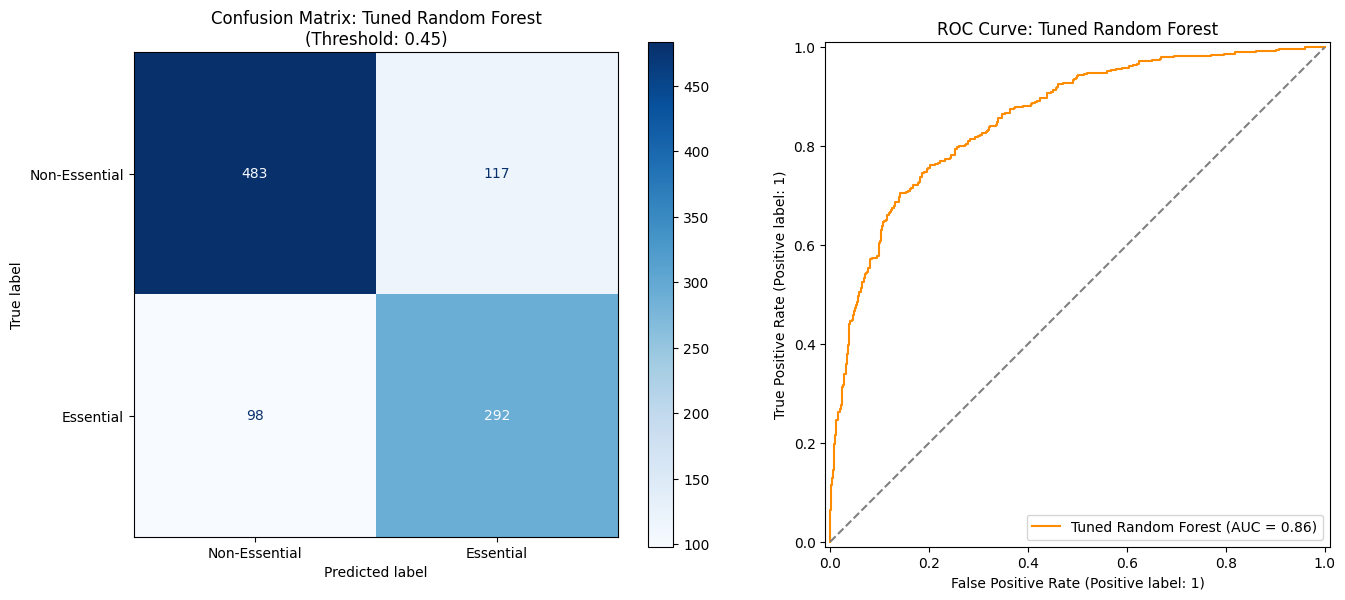

d:\python_progs\final_proj\.venv\Lib\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


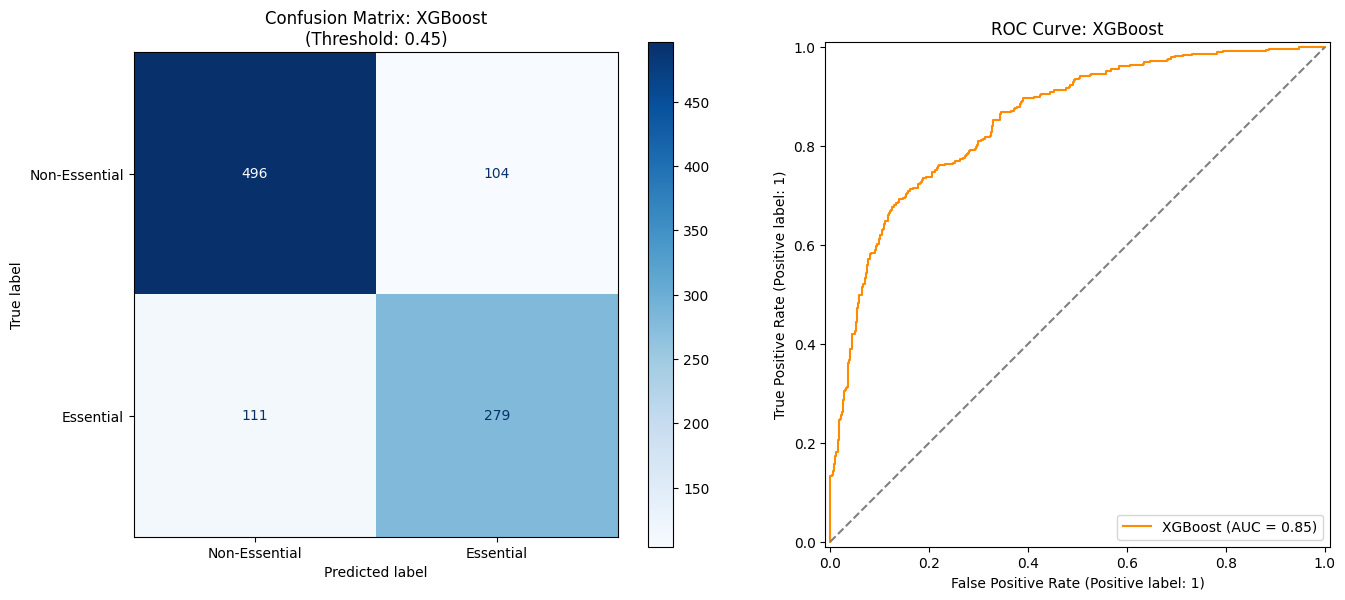

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def plot_metrics(model, X, y, threshold=0.45, name="Model"):
    # Get probabilities and apply threshold
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)

    # Create a figure with two subplots (Confusion Matrix and ROC)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Plot Confusion Matrix (Respects the 0.45 threshold)
    ConfusionMatrixDisplay.from_predictions(
        y, preds, 
        ax=ax1, 
        cmap='Blues', 
        display_labels=["Non-Essential", "Essential"]
    )
    ax1.set_title(f"Confusion Matrix: {name}\n(Threshold: {threshold})")

    # 2. Plot ROC-AUC Curve
    RocCurveDisplay.from_predictions(
        y, probs, 
        ax=ax2, 
        name=name, 
        color='darkorange'
    )
    ax2.plot([0, 1], [0, 1], linestyle="--", color="gray") # Diagonal line for random guess
    ax2.set_title(f"ROC Curve: {name}")

    plt.tight_layout()
    plt.show()

# Generate plots for both models
plot_metrics(best_rf_model, X_test_scaled, y_test, threshold=0.45, name="Tuned Random Forest")
plot_metrics(xgb_model, X_test_scaled, y_test, threshold=0.45, name="XGBoost")